# Import Dependencies

In [1]:
import os
import copy
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from collections import OrderedDict
import tqdm
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import time
from torch.autograd import Variable
from torch.nn import CrossEntropyLoss
torch.serialization.add_safe_globals([CrossEntropyLoss])
torch.serialization.add_safe_globals([set])
%matplotlib inline
import Augmentor
import torchvision

In [2]:
#!pip3 install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/competitions/2024-fall-ml-3-hw-2-dog-identification/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  eileanorplarocco


Your Kaggle Key:

  ········


100%|██████████| 345M/345M [00:01<00:00, 259MB/s] 



Extracting archive ./2024-fall-ml-3-hw-2-dog-identification/2024-fall-ml-3-hw-2-dog-identification.zip to ./2024-fall-ml-3-hw-2-dog-identification


In [3]:
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = device = torch.device("cuda")
print(device)

cuda


# Load Data

In [4]:
data_dir = "./2024-fall-ml-3-hw-2-dog-identification" # Path to data directory
labels = pd.read_csv(os.path.join(data_dir, 'labels.csv'))
assert(len(os.listdir(os.path.join(data_dir, 'train/train'))) == len(labels))

In [5]:
len(os.listdir(os.path.join(data_dir, 'train/train')))

8000

In [6]:
import Augmentor
p = Augmentor.Pipeline(os.path.join(data_dir, 'train/train'))
p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=20)
p.zoom(probability=0.3, min_factor=1.05, max_factor=1.1)
p.skew_tilt(probability=0.3)
p.flip_left_right(probability = 0.7)
p.random_brightness(probability=0.5, min_factor=0.5, max_factor=1.5)
#p.sample(1000)

Initialised with 8000 image(s) found.
Output directory set to ./2024-fall-ml-3-hw-2-dog-identification/train/train/output.

In [7]:
class_labels = labels.sort_values(by = 'breed', ascending = True)
class_labels = class_labels.breed.unique()
class_labels = class_labels.tolist()

In [8]:
le = LabelEncoder()
labels.breed = le.fit_transform(labels.breed)
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,19
1,001513dfcb2ffafc82cccf4d8bbaba97,37
2,001cdf01b096e06d78e9e5112d419397,85
3,00214f311d5d2247d5dfe4fe24b2303d,15
4,0021f9ceb3235effd7fcde7f7538ed62,49


In [9]:
X = labels.id
y = labels.breed

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=SEED, stratify=y) #60% train, stratified by label
#X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=SEED, stratify=y_valid) #20% test, 20% validation - stratified by label

In [10]:
class Dataset_Interpreter(Dataset):
    def __init__(self, data_path, file_names, labels=None, transforms=None):
        self.data_path = data_path
        self.file_names = file_names
        self.labels = labels
        self.transforms = transforms
        
    def __len__(self):
        return (len(self.file_names))
    
    def __getitem__(self, idx):
        img_name = f'{self.file_names.iloc[idx]}.jpg'
        full_address = os.path.join(self.data_path, img_name)
        image = Image.open(full_address)

        if self.labels is not None:
            label = self.labels.iloc[idx]
        
        if self.transforms is not None:
            image = self.transforms(image)

        if self.labels is not None:    
            return np.array(image), label
        
        if self.labels is None:
            return np.array(image)

In [11]:
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20,10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title(f'{le.inverse_transform([images[i][1]])}')
        ax.imshow(np.array(images[i][0]))
        ax.axis('off')

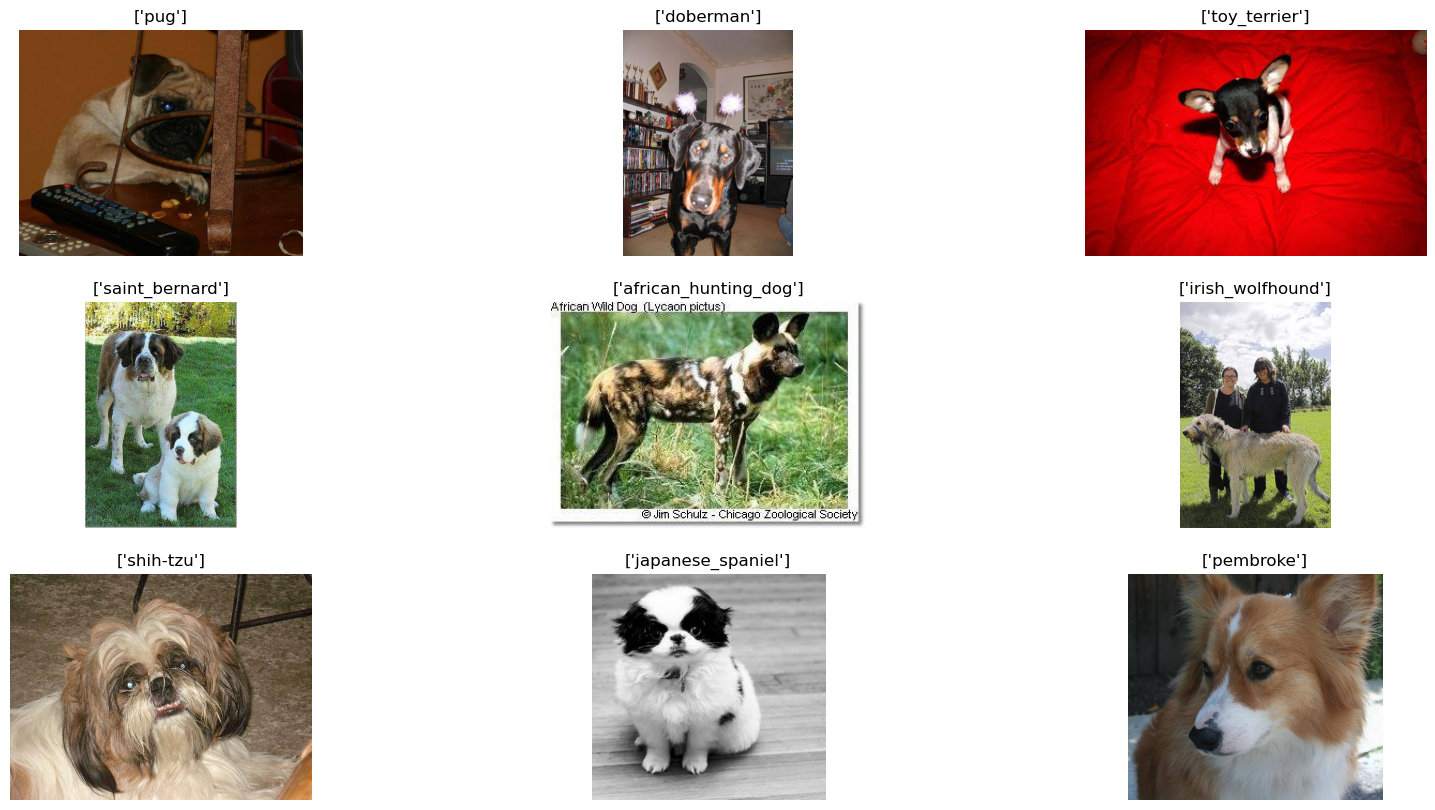

In [12]:
# Transform and Plot Sample Test Images
N_IMAGES = 9

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    p.torch_transform(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = Dataset_Interpreter(data_path=data_dir+'/train/train/', file_names=X_train, labels=y_train, transforms=transforms)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_data = Dataset_Interpreter(data_path=data_dir+'/train/train/', file_names=X_test, labels=y_test, transforms=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)
#valid_data = Dataset_Interpreter(data_path=data_dir+'/train/train/', file_names=X_valid, labels=y_valid, transforms=transform)
#valid_loader = DataLoader(valid_data, batch_size=64, shuffle=True)

sample_data = Dataset_Interpreter(data_path=data_dir+'/train/train/', file_names=X_test, labels=y_test)
images = [(image, label) for image, label in [sample_data[i] for i in range(N_IMAGES)]] 
plot_images(images)

# Create Model
#### Design and instantiate a neural network architecture suitable for the classification task at hand. -- transfer learning

In [13]:
# 224 x 224 crop
#conv -> bn -> activation
#SGD with mini batch size 256
#learning rate = 0.1 then 0.1/10 when plateaus
#no dropout
#identity mapping - input dim = output dim

class bottleneck_block(nn.Module): #create "bottleneck building block" for ResNet 50 (expanded from resnet 34) for more efficiency
    def __init__(self, in_channels, out_channels, downsample=None, stride=1):
        super(bottleneck_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0) #1x1, 64
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1) #3x3, 64 - padding because no longer kernel_size 1
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*4, kernel_size=1, stride=1, padding=0) #1x1, 256 (64 x expansion factor of 4)
        self.bn3 = nn.BatchNorm2d(out_channels*4)
        self.downsample = downsample #use if need to change shape
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            identity = self.downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet50(nn.Module): # [3,4,6,3] - first layer 3 blocks, second layer 4 blocks, etc.
    def __init__(self, bottleneck_block): # layers = how many times to call block
        super(ResNet50, self).__init__()
        self.in_channels = 64

        #Initial Layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3) # 7x7, 64, stride 2
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        #ResNet Layers
        self.layer1 = self.layer(bottleneck_block, num_blocks=3, out_channels=64, stride=1)
        self.layer2 = self.layer(bottleneck_block, num_blocks=4, out_channels=128, stride=2)
        self.layer3 = self.layer(bottleneck_block, num_blocks=6, out_channels=256, stride=2)
        self.layer4 = self.layer(bottleneck_block, num_blocks=3, out_channels=512, stride=2) #512*4 = 2048 channnels

        self.avgpool = nn.AdaptiveAvgPool2d((1,1)) #fix to 1x1 size
        self.fc = nn.Linear(512*4, 120)


    def forward(self, x):
        x = self.conv1(x)
        #print(x.size()) #starts off with stride 2 so should be 112 if input size 224
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #print(x.size()) #56x56

        x = self.layer1(x)
        #print(x.size()) #56x56
        x = self.layer2(x)
        #print(x.size()) #28x28
        x = self.layer3(x)
        #print(x.size()) #14x14
        x = self.layer4(x)
        #print(x.size()) #7x7

        x = self.avgpool(x)
        #print(x.size()) #1x1
        x = x.reshape(x.shape[0], -1)
        #print(x.size()) #2048 outputs
        x = self.fc(x)
        #print(x.size()) #120 outputs

        return x


    def layer(self, block, num_blocks, out_channels, stride):
        downsample = None
        layers = []

        if stride != 1 or self.in_channels != out_channels*4: #identity mapping to overcome degredation problem
            downsample = nn.Sequential(nn.Conv2d(self.in_channels
                                                          , out_channels*4
                                                          , kernel_size=1
                                                          , stride=stride)
                                                          , nn.BatchNorm2d(out_channels*4))
        layers.append(block(self.in_channels, out_channels, downsample, stride)) #changes the # of channels
        self.in_channels = out_channels*4

        for i in range(num_blocks - 1):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers) #*unpacks list

def test():
    net = ResNet50(bottleneck_block)
    x = torch.randn(2,3,224,224)
    y = net(x).to(device)
    print(y.shape)

test()

torch.Size([2, 120])


# Training and Validation
#### Implement effective training loops, validation checks, and possibly other regularization techniques to achieve optimal model performance.

In [14]:
plt.style.use('ggplot')
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            #print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save(model.state_dict(), 'outputs/best_model.tar')

In [15]:
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save(model.state_dict(), 'outputs/final_model.tar')

In [16]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('outputs/accuracy.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('outputs/loss.png')

In [17]:
torch.optim.lr_scheduler

# learning_parameters 
lr = 0.1

# epochs
epochs = 75

# model
model = ResNet50(bottleneck_block)
model.to(device)

# parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

# optimizer
optimizer = optim.SGD(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.0001, threshold_mode='rel')
#scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

# loss function
criterion = nn.CrossEntropyLoss()

# initialize SaveBestModel class
save_best_model = SaveBestModel()

23,780,472 total parameters.
23,780,472 training parameters.



In [18]:
# training
def train(model, trainloader, optimizer, criterion):
    model.train()
    #print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in enumerate(trainloader):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [19]:
# validation
def validate(model, testloader, criterion):
    model.eval()
    #print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in enumerate(testloader):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [20]:
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# start the training
for epoch in range(epochs):
    
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                            optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, test_loader,  
                                                criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    #print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    #print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    # save the best model till now if we have the least loss in the current epoch
    save_best_model(
        valid_epoch_loss, epoch, model, optimizer, criterion
    )
    #print('-'*50)
    scheduler.step(valid_epoch_loss)
    print(f'learning rate: {scheduler.get_last_lr()}')
    
# save the trained model weights for a final time
save_model(epochs, model, optimizer, criterion)
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

[INFO]: Epoch 1 of 75

Best validation loss: 4.812750196456909
learning rate: [0.1]
[INFO]: Epoch 2 of 75
learning rate: [0.1]
[INFO]: Epoch 3 of 75

Best validation loss: 4.800627937316895
learning rate: [0.1]
[INFO]: Epoch 4 of 75
learning rate: [0.1]
[INFO]: Epoch 5 of 75
learning rate: [0.1]
[INFO]: Epoch 6 of 75

Best validation loss: 4.686937255859375
learning rate: [0.1]
[INFO]: Epoch 7 of 75
learning rate: [0.1]
[INFO]: Epoch 8 of 75

Best validation loss: 4.5331331157684325
learning rate: [0.1]
[INFO]: Epoch 9 of 75

Best validation loss: 4.456105947494507
learning rate: [0.1]
[INFO]: Epoch 10 of 75
learning rate: [0.1]
[INFO]: Epoch 11 of 75

Best validation loss: 4.335552816390991
learning rate: [0.1]
[INFO]: Epoch 12 of 75
learning rate: [0.1]
[INFO]: Epoch 13 of 75
learning rate: [0.1]
[INFO]: Epoch 14 of 75
learning rate: [0.1]
[INFO]: Epoch 15 of 75

Best validation loss: 4.04443932056427
learning rate: [0.1]
[INFO]: Epoch 16 of 75

Best validation loss: 4.03620471000671

KeyboardInterrupt: 

# Submission CSV

In [21]:
# Load model
model = ResNet50(bottleneck_block)
model.load_state_dict(torch.load("outputs/best_model.tar", weights_only=True))
#model.to(device)

<All keys matched successfully>

In [22]:
def get_filenames_without_extensions(directory):
    """Gets a list of filenames without extensions in the given directory."""

    filenames = []
    for filename in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, filename)):
            base, ext = os.path.splitext(filename)
            filenames.append(base)
    return filenames

In [23]:
ids = get_filenames_without_extensions(os.path.join(data_dir, 'test/test')) #get all file names in test folder
submission_names = pd.DataFrame({'id' : ids})
submission_names = submission_names.id

In [24]:
sub_data = Dataset_Interpreter(data_path=data_dir+'/test/test/', file_names=submission_names, transforms=transform)
sub_loader = DataLoader(sub_data, batch_size=64, shuffle=False)

In [25]:
all_probabilities = []
with torch.no_grad():
    for batch in sub_loader:
        #inputs = batch['input']  # Adjust according to your dataset
        outputs = model(batch)
        probabilities = torch.softmax(outputs, dim=1)
        all_probabilities.append(probabilities.cpu().numpy())

# Concatenate probabilities from all batches
all_probabilities = np.concatenate(all_probabilities, axis=0)

# Create a DataFrame
df = pd.DataFrame(all_probabilities, columns=class_labels)
df.insert(0, 'id', ids)

# Save to CSV
df.to_csv('outputs/my_submission_resnet.csv', index=False)